In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
    
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [2]:
df = pd.DataFrame(report)
df

,cost_le,cost_leq,cost_tuple_cons,cost_pow,cost_tuple_merge,cost_mod,cost_geq,cost_log2,cost_or,cost_ge,cost_sqrti,cost_and,cost_add,cost_tuple_get,cost_sub
2,1339.918396,1321.920384,1.963484e+03,1380.114496,6985.564813,1381.750132,1397.543069,NaN,1294.274336,1367.630817,NaN,1275.241153,1496.360473,3.575483e+03,1558.674977
32,NaN,NaN,1.300636e+04,NaN,69508.381934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2623.654398,2.628580e+04,2740.550371
2048,NaN,NaN,1.208290e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.989479e+06,NaN
256,NaN,NaN,1.231067e+05,NaN,610597.701501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8211.597051,2.212434e+05,8262.581920
16,NaN,NaN,6.827264e+03,NaN,34989.532020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2131.589604,1.375831e+04,2214.332757
1,NaN,NaN,1.737737e+03,NaN,5365.436321,NaN,NaN,1374.8162,NaN,NaN,1559.526032,NaN,1418.405749,3.006526e+03,1459.810144
8,NaN,NaN,3.773141e+03,NaN,17811.181006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1818.589641,7.421509e+03,1845.096452
128,NaN,NaN,5.760926e+04,NaN,300139.452604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5193.530000,1.082943e+05,5353.140021
64,NaN,NaN,2.607264e+04,NaN,140566.731318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3546.915754,5.233281e+04,3589.280675
4096,NaN,NaN,2.576230e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.297094e+06,NaN


In [3]:
def estimate_params(df, name, transform):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    X = transform(X)
#     Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b, transform):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    X = transform(X)
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output, transform = lambda x: x):
    a, b = estimate_params(df, fun_name, transform)
    output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    plot(df, fun_name, a, b, transform)

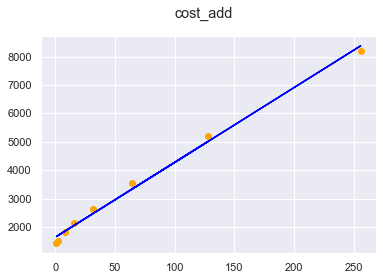

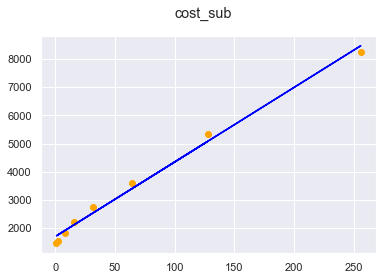

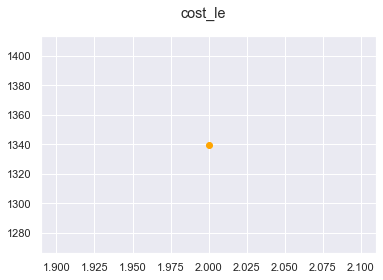

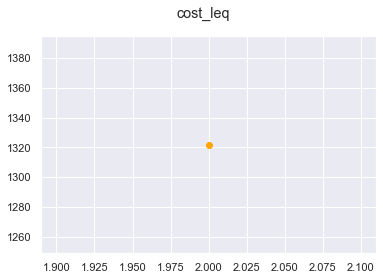

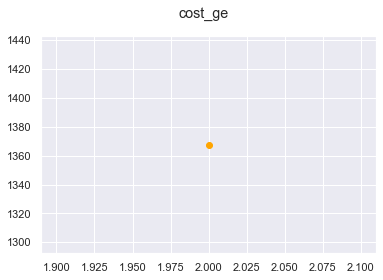

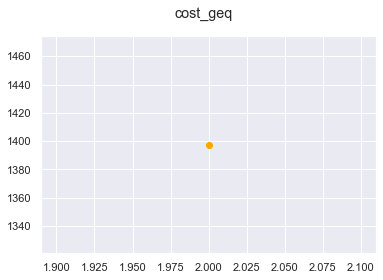

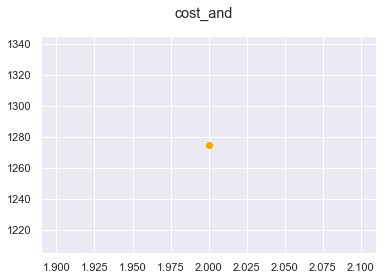

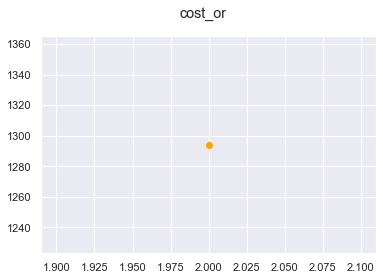

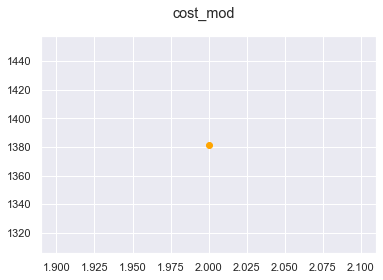

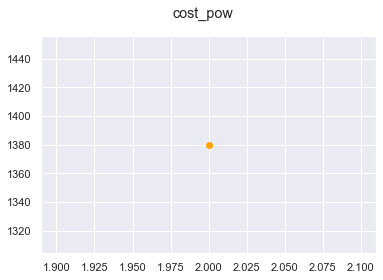

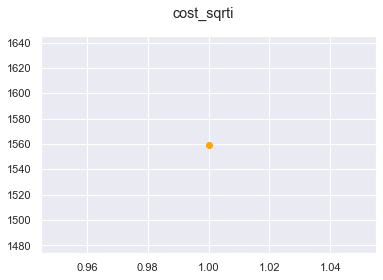

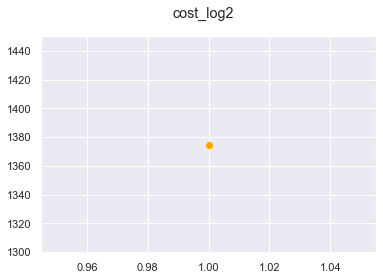

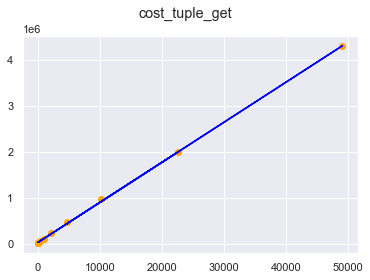

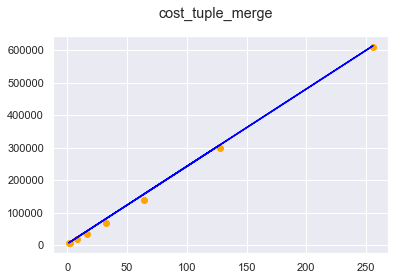

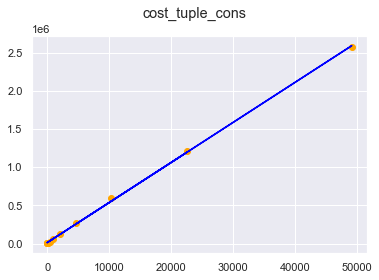

,a,b
cost_add,26.34777629469493,1635.290011
cost_sub,26.432863596256205,1702.750684
cost_le,0.0,1339.918396
cost_leq,0.0,1321.920384
cost_ge,0.0,1367.630817
cost_geq,0.0,1397.543069
cost_and,0.0,1275.241153
cost_or,0.0,1294.274336
cost_mod,0.0,1381.750132
cost_pow,0.0,1380.114496


In [7]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_mod', output)
estimate_plot(df, 'cost_pow', output)
estimate_plot(df, 'cost_sqrti', output)
estimate_plot(df, 'cost_log2', output)
estimate_plot(df, 'cost_tuple_get', output, nlogn)
estimate_plot(df, 'cost_tuple_merge', output)
estimate_plot(df, 'cost_tuple_cons', output, nlogn)

output

In [5]:
output.to_csv("cost_constants.csv")

In [9]:
71241.3539776112 2.126736e+07

SyntaxError: invalid syntax (<ipython-input-9-1110dabad65a>, line 1)